# Face detection and recognition training pipeline

The following example illustrates how to fine-tune an InceptionResnetV1 model on your own dataset. This will mostly follow standard pytorch training patterns.

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import Dataset,DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

/home/lamnvs/Venv/facenet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define run parameters

The dataset should follow the VGGFace2/ImageNet-style directory layout. Modify `data_dir` to the location of the dataset on wish to finetune on.

In [2]:
data_dir = '../VN-celeb'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

#### Determine if an nvidia GPU is available

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

See `help(MTCNN)` for more details.

In [3]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device='cpu'
)

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and obtain cropped faces.

In [6]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

/home/lamnvs/Venv/facenet/lib/python3.8/site-packages/torch-1.11.0-py3.8-linux-x86_64.egg/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/home/lamnvs/Venv/facenet/lib/python3.8/site-packages/facenet_pytorch-2.5.2-py3.8.egg/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/home/lamnvs/Venv/facenet/lib/python3.8/site-packages/facenet_pytorch-2.5.2-py3.8.egg/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an nda

Batch 1 of 723

/home/lamnvs/Venv/facenet/lib/python3.8/site-packages/facenet_pytorch-2.5.2-py3.8.egg/facenet_pytorch/models/mtcnn.py:444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_boxes = np.array(selected_boxes)
/home/lamnvs/Venv/facenet/lib/python3.8/site-packages/facenet_pytorch-2.5.2-py3.8.egg/facenet_pytorch/models/mtcnn.py:446: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_points = np.array(selected_points)


Batch 723 of 723

#### Define Inception Resnet V1 module

See `help(InceptionResnetV1)` for more details.

In [4]:
resnet = InceptionResnetV1(
    classify=False,
    pretrained='vggface2',
).to(device)

In [5]:
resnet.eval()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

#### Define optimizer, scheduler, dataset, and dataloader

In [12]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

#### Define loss and evaluation functions

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

#### Train model

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()

In [7]:
import random
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

# setting the root directories and categories of the images
# root_dir = './images_background/'
root_dir = '../VN-celeb/'
person_ids = [[folder, os.listdir(root_dir + folder)] for folder in os.listdir(root_dir)  if not folder.startswith('.') ]

# creates n-way one shot learning evaluation
class NWayOneShotEvalSet(Dataset):
    def __init__(self, person_ids, root_dir, setSize, numWay, transform=None):
        self.person_ids = person_ids
        self.root_dir = root_dir
        self.setSize = setSize
        self.numWay = numWay
        self.transform = transform
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        # find one main image
        mainImg = None
        while mainImg is None:
            person_id = random.choice(self.person_ids)
            img_id = random.choice(person_id[1])
            imgDir = self.root_dir + person_id[0]
            main_name = imgDir + '/' + img_id
            mainImg = Image.open(imgDir + '/' + img_id)
            # print(imgDir + '/' + imgName)
            mainImg = mtcnn(mainImg)
        if self.transform:
            mainImg = self.transform(mainImg)
        
        # find n numbers of distinct images, 1 in the same set as the main
        testSet = []
        testNames = []
        label = np.random.randint(self.numWay)
        
        for i in range(self.numWay):
            testImg = None
            while testImg is None:
                testImgDir = imgDir
                testImgName = ''
                if i == label:
                    testImgName = random.choice(person_id[1])
                else:
                    testperson = random.choice(self.person_ids)
                    testImgName = random.choice(testperson[1])
                    testImgDir = root_dir + testperson[0]
                    while testImgDir == imgDir:
                        testperson = random.choice(self.person_ids)
                        testImgName = random.choice(testperson[1])
                        testImgDir = root_dir + testperson[0]
                testImg = Image.open(testImgDir + '/' + testImgName)
                testImg = mtcnn(testImg)
            testNames.append(testImgDir + '/' + testImgName)
            if self.transform:
                testImg = self.transform(testImg)
            testSet.append(testImg)
        # plt.imshow()
        return mainImg, testSet, torch.from_numpy(np.array([label], dtype = int)), main_name, testNames

transformations = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
]) 

# create the test set for final testing
testSize = 5000 
numWay = 4
test_set = NWayOneShotEvalSet(person_ids, root_dir, testSize, numWay, None)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 2, shuffle=True)

In [6]:
from torch import dot
from torch.linalg import norm

def similarity(x, y):
    x = x.view(-1)
    y = y.view(-1)
    return dot(x, y)/(norm(x)*norm(y))

In [8]:
# evaluation metrics
def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        for mainImg, imgSets, label, main_name, test_name in test_loader:
            mainImg = mainImg.to(device)
            mainOut = model(mainImg)
            bestSim = 0
            pred = -1
            for i, testImg in enumerate(imgSets):
                testImg = testImg.to(device)
                testOut = model(testImg)
                sim = similarity(mainOut, testOut)
                if sim > bestSim:
                    pred = i
                    bestSim = sim
            label = label.to(device)
            #print(main_name, test_name[pred])
            if pred == label:
                correct += 1
            count += 1
            if count % 20 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on n way: {}'.format(correct/count))

In [14]:
eval(resnet, test_loader)

Starting Iteration


/home/lamnvs/Venv/facenet/lib/python3.8/site-packages/torch-1.11.0-py3.8-linux-x86_64.egg/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/home/lamnvs/Venv/facenet/lib/python3.8/site-packages/torch-1.11.0-py3.8-linux-x86_64.egg/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Current Count is: 20
Accuracy on n way: 0.9
Current Count is: 40
Accuracy on n way: 0.95
Current Count is: 60
Accuracy on n way: 0.9666666666666667
Current Count is: 80
Accuracy on n way: 0.9375
Current Count is: 100
Accuracy on n way: 0.93
Current Count is: 120
Accuracy on n way: 0.9333333333333333
Current Count is: 140
Accuracy on n way: 0.9285714285714286
Current Count is: 160
Accuracy on n way: 0.93125
Current Count is: 180
Accuracy on n way: 0.9222222222222223
Current Count is: 200
Accuracy on n way: 0.92
Current Count is: 220
Accuracy on n way: 0.9227272727272727
Current Count is: 240
Accuracy on n way: 0.925
Current Count is: 260
Accuracy on n way: 0.9307692307692308
Current Count is: 280
Accuracy on n way: 0.9321428571428572
Current Count is: 300
Accuracy on n way: 0.9333333333333333
Current Count is: 320
Accuracy on n way: 0.9375
Current Count is: 340
Accuracy on n way: 0.9323529411764706
Current Count is: 360
Accuracy on n way: 0.9361111111111111
Current Count is: 380
Accurac

In [17]:
import glob, os
count_img = 0
f = open('test_list_2.txt', 'w')
for person_1 in glob.glob('../VN-celeb_cropped/*/*.png'):
    path1, name1 = person_1.rsplit('/', 1)
    for person_2 in glob.glob('../VN-celeb_cropped/*/*.png'):
        path2, name2 = person_2.rsplit('/', 1)
        if path1 == path2:
            f.write(f'{path1} {name1} {name2}\n')
        else:
            f.write(f'{path1} {name1} {path2} {name2}\n')
count_img

0

In [3]:
import os
import random
import glob

min_len = -1

f = open('test_list.txt', 'w')
for person_folder in glob.glob('../VN-celeb_cropped/*'):
    try:
        random_id = random.sample(os.listdir(person_folder), 4)
        for idx in range(0, len(random_id), 2):
            f.write(f'{person_folder} {random_id[idx]} {random_id[idx+1]}\n')
    except ValueError as err:
        random_id = os.listdir(person_folder)[:2]
        f.write(f'{person_folder} {random_id[0]} {random_id[1]}\n')
print(min_len)

-1


In [8]:
neg_pair = set()
while len(neg_pair) < 2000:
    pair = random.sample(glob.glob('../VN-celeb_cropped/*/*.png', recursive=True), 2)
    if pair[0].split('/')[2] == pair[1].split('/')[2]:
        continue
    neg_pair.add((pair[0], pair[1]))

In [10]:
for pair in neg_pair:
    path0, id0 = pair[0].rsplit('/', 1)
    path1, id1 = pair[1].rsplit('/', 1)
    f.write(f'{path0} {id0} {path1} {id1}\n')

In [19]:
import torchvision.datasets as datasets
import os
import numpy as np


class LFWDataset(Dataset):
    def __init__(self, pairs_path, transform=None):

        super(LFWDataset, self).__init__()

        self.pairs_path = pairs_path
        self.transform = transform
        # LFW dir contains 2 folders: faces and lists
        self.validation_images = self.get_lfw_paths()

    def read_lfw_pairs(self, pairs_filename):
        pairs = []
        with open(pairs_filename, 'r') as f:
            for line in f.readlines():
                pair = line.strip().split()
                pairs.append(pair)

        return np.array(pairs, dtype=object)

    def get_lfw_paths(self):
        pairs = self.read_lfw_pairs(self.pairs_path)

        nrof_skipped_pairs = 0
        path_list = []
        issame_list = []
        for pair in pairs:
            if len(pair) == 3:
                path0 = os.path.join(pair[0], pair[1])
                path1 = os.path.join(pair[0], pair[2])
                issame = True
            elif len(pair) == 4:
                path0 = os.path.join(pair[0], pair[1])
                path1 = os.path.join(pair[2], pair[3])
                issame = False
            if os.path.exists(path0) and os.path.exists(path1):  # Only add the pair if both paths exist
                path_list.append((path0, path1, issame))
                issame_list.append(issame)
            else:
                nrof_skipped_pairs += 1
        if nrof_skipped_pairs > 0:
            print('Skipped %d image pairs' % nrof_skipped_pairs)

        return path_list


    def __getitem__(self, index):
        """
        Args:
            index: Index of the triplet or the matches - not of a single image
        Returns:
        """

        def transform(img_path):
            """Convert image into numpy array and apply transformation
               Doing this so that it is consistent with all other datasets
               to return a PIL Image.
            """

            img = pil_loader(img_path)
            return self.transform(img)

        (path_1, path_2, issame) = self.validation_images[index]
        img1, img2 = transform(path_1), transform(path_2)
        return img1, img2, issame

    def __len__(self):
        return len(self.validation_images)

In [20]:
lfw_dataloader = DataLoader(
        dataset=LFWDataset(
            pairs_path='/home/lamnvs/facenet_pytorch/examples/test_list_2.txt',
            transform=transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
        ),
        batch_size=256,
        num_workers=2,
        shuffle=False
    )

In [39]:
best_distances = validate_lfw(resnet, lfw_dataloader, 'resnext', 0)

Validating on LFW! ...


100%|██████████| 123/123 [00:09<00:00, 12.75it/s]


Accuracy on LFW: 0.8797+-0.0188	Precision 0.5600+-0.4716	Recall 0.5301+-0.4337	ROC Area Under Curve: 0.2605	Best distance threshold: 0.49+-0.02	TAR: 0.2930+-0.2397 @ FAR: 0.0003


In [32]:
from torch.nn.modules.distance import PairwiseDistance
from torch.nn import CosineSimilarity
from tqdm import tqdm


def validate_lfw(model, lfw_dataloader, model_architecture, epoch):
    model.eval()
    with torch.no_grad():
        l2_distance = CosineSimilarity()#PairwiseDistance(p=2)
        distances, labels = [], []

        print("Validating on LFW! ...")
        progress_bar = enumerate(tqdm(lfw_dataloader))

        for batch_index, (data_a, data_b, label) in progress_bar:
            data_a = data_a.cuda()
            data_b = data_b.cuda()

            output_a, output_b = model(data_a), model(data_b)
            distance = l2_distance(output_a, output_b)#l2_distance.forward(output_a, output_b)  # Euclidean distance

            distances.append(distance.cpu().detach().numpy())
            labels.append(label.cpu().detach().numpy())

        labels = np.array([sublabel for label in labels for sublabel in label])
        distances = np.array([subdist for distance in distances for subdist in distance])

        true_positive_rate, false_positive_rate, precision, recall, accuracy, roc_auc, best_distances, \
        tar, far = evaluate_lfw(
            distances=distances,
            labels=labels,
            far_target=1e-3
        )
        # Print statistics and add to log
        print("Accuracy on LFW: {:.4f}+-{:.4f}\tPrecision {:.4f}+-{:.4f}\tRecall {:.4f}+-{:.4f}\t"
              "ROC Area Under Curve: {:.4f}\tBest distance threshold: {:.2f}+-{:.2f}\t"
              "TAR: {:.4f}+-{:.4f} @ FAR: {:.4f}".format(
                    np.mean(accuracy),
                    np.std(accuracy),
                    np.mean(precision),
                    np.std(precision),
                    np.mean(recall),
                    np.std(recall),
                    roc_auc,
                    np.mean(best_distances),
                    np.std(best_distances),
                    np.mean(tar),
                    np.std(tar),
                    np.mean(far)
                )
        )
        with open('logs/lfw_{}_log_triplet.txt'.format(model_architecture), 'a') as f:
            val_list = [
                epoch,
                np.mean(accuracy),
                np.std(accuracy),
                np.mean(precision),
                np.std(precision),
                np.mean(recall),
                np.std(recall),
                roc_auc,
                np.mean(best_distances),
                np.std(best_distances),
                np.mean(tar)
            ]
            log = '\t'.join(str(value) for value in val_list)
            f.writelines(log + '\n')

    try:
        # Plot ROC curve
        plot_roc_lfw(
            false_positive_rate=false_positive_rate,
            true_positive_rate=true_positive_rate,
            figure_name="plots/roc_plots/roc_{}_epoch_{}_triplet.png".format(model_architecture, epoch)
        )
        # Plot LFW accuracies plot
        plot_accuracy_lfw(
            log_file="logs/lfw_{}_log_triplet.txt".format(model_architecture),
            epochs=epoch,
            figure_name="plots/accuracies_plots/lfw_accuracies_{}_epoch_{}_triplet.png".format(model_architecture, epoch)
        )
    except Exception as e:
        print(e)

    return best_distances

In [38]:
import numpy as np
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from scipy import interpolate


def evaluate_lfw(distances, labels, num_folds=10, far_target=1e-3):
    """Evaluates on the Labeled Faces in the Wild dataset using KFold cross validation based on the Euclidean
    distance as a metric.
    Note: "TAR@FAR=0.001" means the rate that faces are successfully accepted (True Acceptance Rate) (TP/(TP+FN)) when
    the rate that faces are incorrectly accepted (False Acceptance Rate) (FP/(TN+FP)) is 0.001 (The less the FAR value
    the mode difficult it is for the model). i.e: 'What is the True Positive Rate of the model when only one false image
    in 1000 images is allowed?'.
        https://github.com/davidsandberg/facenet/issues/288#issuecomment-305961018
    Args:
        distances: numpy array of the pairwise distances calculated from the LFW pairs.
        labels: numpy array containing the correct result of the LFW pairs belonging to the same identity or not.
        num_folds (int): Number of folds for KFold cross-validation, defaults to 10 folds.
        far_target (float): The False Acceptance Rate to calculate the True Acceptance Rate (TAR) at,
                             defaults to 1e-3.
    Returns:
        true_positive_rate: Mean value of all true positive rates across all cross validation folds for plotting
                             the Receiver operating characteristic (ROC) curve.
        false_positive_rate: Mean value of all false positive rates across all cross validation folds for plotting
                              the Receiver operating characteristic (ROC) curve.
        accuracy: Array of accuracy values per each fold in cross validation set.
        precision: Array of precision values per each fold in cross validation set.
        recall: Array of recall values per each fold in cross validation set.
        roc_auc: Area Under the Receiver operating characteristic (AUROC) metric.
        best_distances: Array of Euclidean distance values that had the best performing accuracy on the LFW dataset
                         per each fold in cross validation set.
        tar: Array that contains True Acceptance Rate values per each fold in cross validation set
              when far (False Accept Rate) is set to a specific value.
        far: Array that contains False Acceptance Rate values per each fold in cross validation set.
    """

    # Calculate ROC metrics
    thresholds_roc = np.arange(0, 4, 0.01)
    true_positive_rate, false_positive_rate, precision, recall, accuracy, best_distances = \
        calculate_roc_values(
            thresholds=thresholds_roc, distances=distances, labels=labels, num_folds=num_folds
        )

    roc_auc = auc(false_positive_rate, true_positive_rate)

    # Calculate validation rate
    thresholds_val = np.arange(0, 4, 0.001)
    tar, far = calculate_val(
        thresholds_val=thresholds_val, distances=distances, labels=labels, far_target=far_target, num_folds=num_folds
    )

    return true_positive_rate, false_positive_rate, precision, recall, accuracy, roc_auc, best_distances,\
        tar, far


def calculate_roc_values(thresholds, distances, labels, num_folds=10):
    num_pairs = min(len(labels), len(distances))
    num_thresholds = len(thresholds)
    k_fold = KFold(n_splits=num_folds, shuffle=False)

    true_positive_rates = np.zeros((num_folds, num_thresholds))
    false_positive_rates = np.zeros((num_folds, num_thresholds))
    precision = np.zeros(num_folds)
    recall = np.zeros(num_folds)
    accuracy = np.zeros(num_folds)
    best_distances = np.zeros(num_folds)

    indices = np.arange(num_pairs)

    for fold_index, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # Find the best distance threshold for the k-fold cross validation using the train set
        accuracies_trainset = np.zeros(num_thresholds)
        for threshold_index, threshold in enumerate(thresholds):
            _, _, _, _, accuracies_trainset[threshold_index] = calculate_metrics(
                threshold=threshold, dist=distances[train_set], actual_issame=labels[train_set]
            )
        best_threshold_index = np.argmax(accuracies_trainset)

        # Test on test set using the best distance threshold
        for threshold_index, threshold in enumerate(thresholds):
            true_positive_rates[fold_index, threshold_index], false_positive_rates[fold_index, threshold_index], _, _,\
                _ = calculate_metrics(
                    threshold=threshold, dist=distances[test_set], actual_issame=labels[test_set]
                )

        _, _, precision[fold_index], recall[fold_index], accuracy[fold_index] = calculate_metrics(
            threshold=thresholds[best_threshold_index], dist=distances[test_set], actual_issame=labels[test_set]
        )

        true_positive_rate = np.mean(true_positive_rates, 0)
        false_positive_rate = np.mean(false_positive_rates, 0)
        best_distances[fold_index] = thresholds[best_threshold_index]

    return true_positive_rate, false_positive_rate, precision, recall, accuracy, best_distances


def calculate_metrics(threshold, dist, actual_issame):
    # If distance is less than threshold, then prediction is set to True
    predict_issame = np.less(dist, threshold)

    true_positives = np.sum(np.logical_and(predict_issame, actual_issame))
    false_positives = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    true_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    false_negatives = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    # For dealing with Divide By Zero exception
    true_positive_rate = 0 if (true_positives + false_negatives == 0) else \
        float(true_positives) / float(true_positives + false_negatives)

    false_positive_rate = 0 if (false_positives + true_negatives == 0) else \
        float(false_positives) / float(false_positives + true_negatives)

    precision = 0 if (true_positives + false_positives) == 0 else\
        float(true_positives) / float(true_positives + false_positives)

    recall = 0 if (true_positives + false_negatives) == 0 else \
        float(true_positives) / float(true_positives + false_negatives)

    accuracy = float(true_positives + true_negatives) / dist.size

    return true_positive_rate, false_positive_rate, precision, recall, accuracy


def calculate_val(thresholds_val, distances, labels, far_target=1e-3, num_folds=10):
    num_pairs = min(len(labels), len(distances))
    num_thresholds = len(thresholds_val)
    k_fold = KFold(n_splits=num_folds, shuffle=False)

    tar = np.zeros(num_folds)
    far = np.zeros(num_folds)

    indices = np.arange(num_pairs)

    for fold_index, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # Find the euclidean distance threshold that gives false acceptance rate (far) = far_target
        far_train = np.zeros(num_thresholds)
        for threshold_index, threshold in enumerate(thresholds_val):
            _, far_train[threshold_index] = calculate_val_far(
                threshold=threshold, dist=distances[train_set], actual_issame=labels[train_set]
            )
        if np.max(far_train) >= far_target:
            f = interpolate.interp1d(far_train, thresholds_val, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        tar[fold_index], far[fold_index] = calculate_val_far(
            threshold=threshold, dist=distances[test_set], actual_issame=labels[test_set]
        )

    return tar, far


def calculate_val_far(threshold, dist, actual_issame):
    # If distance is less than threshold, then prediction is set to True
    predict_issame = np.less(dist, threshold)

    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))

    num_same = np.sum(actual_issame)
    num_diff = np.sum(np.logical_not(actual_issame))

    if num_diff == 0:
        num_diff = 1
    if num_same == 0:
        return 0, 0

    tar = float(true_accept) / float(num_same)
    far = float(false_accept) / float(num_diff)

    return tar, far

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc


def plot_roc_lfw(false_positive_rate, true_positive_rate, figure_name="roc.png"):
    """Plots the Receiver Operating Characteristic (ROC) curve.
    Args:
        false_positive_rate: False positive rate
        true_positive_rate: True positive rate
        figure_name (str): Name of the image file of the resulting ROC curve plot.
    """
    roc_auc = auc(false_positive_rate, true_positive_rate)
    fig = plt.figure()
    plt.plot(
        false_positive_rate, true_positive_rate, color='red', lw=2, label="ROC Curve (area = {:.4f})".format(roc_auc)
    )
    plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    fig.savefig(figure_name, dpi=fig.dpi)
    plt.close()


def plot_accuracy_lfw(log_file, epochs, figure_name="lfw_accuracies.png"):
    """Plots the accuracies on the Labeled Faces in the Wild dataset over the training epochs.
    Args:
        log_file (str): Path of the log file containing the lfw accuracy values to be plotted.
        epochs (int): Number of training epochs finished.
        figure_name (str): Name of the image file of the resulting lfw accuracies plot.
    """
    with open(log_file, 'r') as f:
        lines = f.readlines()
        epoch_list = [int(line.split('\t')[0]) for line in lines]
        accuracy_list = [round(float(line.split('\t')[1]), 2) for line in lines]

        fig = plt.figure()
        plt.plot(epoch_list, accuracy_list, color='red', label='LFW Accuracy')
        plt.ylim([0.0, 1.05])
        plt.xlim([0, epochs + 1])
        plt.xlabel('Epoch')
        plt.ylabel('LFW Accuracy')
        plt.title('LFW Accuracies plot')
        plt.legend(loc='lower right')
        fig.savefig(figure_name, dpi=fig.dpi)
        plt.close()

In [7]:

from typing import Any
from PIL import Image
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


In [66]:
from torch.nn.modules.distance import PairwiseDistance

l2_distance = PairwiseDistance(2)

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

img1 = pil_loader('/home/lamnvs/facenet_pytorch/VN-celeb_cropped/_cropped5/0.png')
draw1 = img1.copy()
transformed_img1 = trans(img1)
transformed_img1 = transformed_img1.to(device)

img2 = pil_loader('/home/lamnvs/facenet_pytorch/VN-celeb_cropped/_cropped5/3.png')
draw2 = img2.copy()
transformed_img2 = trans(img2)
transformed_img2 = transformed_img2.to(device)

img3 = pil_loader('/home/lamnvs/facenet_pytorch/VN-celeb_cropped/_cropped47/2.png')
draw3 = img3.copy()
transformed_img3 = trans(img3)
transformed_img3 = transformed_img3.to(device)

out = resnet(torch.stack([transformed_img1, transformed_img2, transformed_img3]))

print(l2_distance(out[0], out[1]))
print(l2_distance(out[0], out[2]))

tensor(0.5128, device='cuda:0', grad_fn=<NormBackward1>)
tensor(1.3528, device='cuda:0', grad_fn=<NormBackward1>)


Text(1, -1, '1.3527910709381104')

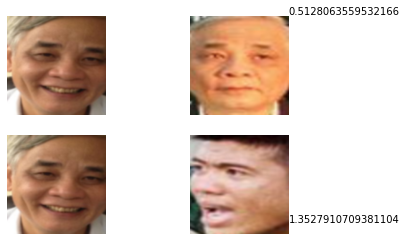

In [67]:
from matplotlib import pyplot as plt
f, axarr = plt.subplots(2,2)
axarr[0,0].set_axis_off()
axarr[0,0].imshow(draw1)
axarr[0,1].set_axis_off()
axarr[0,1].imshow(draw2)
axarr[0,1].text(1, 1, str(l2_distance(out[0], out[1]).item()),
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=axarr[0,1].transAxes)
axarr[1,0].set_axis_off()
axarr[1,0].imshow(draw1)
axarr[1,1].set_axis_off()
axarr[1,1].imshow(draw3)
axarr[1,1].text(1, -1, str(l2_distance(out[0], out[2]).item()),
        horizontalalignment='left',
        verticalalignment='top',
        transform=axarr[0,1].transAxes)
